<a href="https://colab.research.google.com/github/KamilShape/emotion_recognition/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduction**

In [24]:
#Libraries
import os
import cv2
from google.colab.patches import cv2_imshow
import shutil
#----------------visualisation---------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#----------------keras-----------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
#---------------PIL--------------------------
from PIL import Image

In [62]:
data_path = 'drive/MyDrive/faces/data'

In [4]:
# people = ['smiling-person', 'anger-person', 'disgust-person', 'fear-person', 'surprise-person' ]

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# photos_number = []
# for person in people:
#   photos_number.append(len(os.listdir(f'{data_path}/{person}')))

### 1.1 Data visualisation

In [6]:
# fig, ax = plt.subplots(figsize = (8,6))
# ax.bar(people, photos_number, color='wheat', width=0.6)
# ax.set_title('PHOTOS')
# ax.set_ylabel('Amount')

# for i in range(0, len(people)):
#   ax.text(people[i], photos_number[i] - 20, horizontalalignment='center', s=photos_number[i] )

*Dataset is quite balanced.*

# **2. Face detection**

In [8]:
# train_path = 'drive/MyDrive/faces/train'

In [9]:
# test_path = 'drive/MyDrive/faces/test'

In [11]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
def face_recognition(photo, array):
  image = cv2.imread(photo)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  face = face_classifier.detectMultiScale(gray_image, 1.3, 4)
  if len(face) > 0:
   for i, (x, y, w, h) in enumerate(face):
      cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 255), 2)
      face = image[y:y + h, x:x + w]
      array.append(face)

In [60]:
smiling_faces = []
anger_faces = []
disgust_faces = []
fear_faces = []
surprise_faces  = []

In [14]:
def faces_array(array, photos, path):
  files_folder = os.listdir(f'{path}/{photos}')
  print(f'{path}/{photos}')
  for i in range(0, len(files_folder)):
    img_path = f'{path}/{photos}/{files_folder[i]}'
    print(img_path)
    face_recognition(img_path, array)

In [ ]:
faces_array(smiling_faces, "smiling-person", data_path)
faces_array(anger_faces, "anger-person", data_path)
faces_array(disgust_faces, "disgust-person", data_path)
faces_array(fear_faces, "fear-person", data_path)
faces_array(surprise_faces, "surprise-person", data_path)

In [65]:
recognized_faces = {
    'smiling-face': smiling_faces,
    'anger-face' : anger_faces,
    'disgust-face' : disgust_faces,
    'fear-face' : fear_faces,
    'surprise-face' : surprise_faces
}

# **3. Save faces**

In [ ]:
# os.makedirs(f'{path}/{face}', exist_ok=True)
# img.save(f'{path}/{face}/{file_name}', 'png')

In [57]:
faces_path = 'drive/MyDrive/recognized_faces'

In [73]:
for face in recognized_faces:
  os.makedirs(f'{faces_path}', exist_ok=True)
  os.makedirs(f'{faces_path}/{face}', exist_ok=True)
  directory = f'drive/MyDrive/recognized_faces/{face}'
  print(directory)
  os.chdir(directory)
  for i in range(0, len(directory)):
    print(recognized_faces[face][i])
    img = cv2.imread(recognized_faces[face][i])
    # cv2.imwrite(img)
    print(len(recognized_faces[face][0]))

drive/MyDrive/recognized_faces/smiling-face
[[[  0 255 255]
  [  0 255 255]
  [  0 255 255]
  ...
  [  0 255 255]
  [  0 255 255]
  [  0 255 255]]

 [[  0 255 255]
  [  0 255 255]
  [  0 255 255]
  ...
  [  0 255 255]
  [  0 255 255]
  [  0 255 255]]

 [[  0 255 255]
  [  0 255 255]
  [232 228 210]
  ...
  [185 181 157]
  [171 167 149]
  [  0 255 255]]

 ...

 [[  0 255 255]
  [  0 255 255]
  [165 179 191]
  ...
  [134 123  96]
  [149 138 116]
  [  0 255 255]]

 [[  0 255 255]
  [  0 255 255]
  [164 177 191]
  ...
  [110  98  70]
  [121 108  82]
  [  0 255 255]]

 [[  0 255 255]
  [  0 255 255]
  [  0 255 255]
  ...
  [  0 255 255]
  [  0 255 255]
  [  0 255 255]]]


TypeError: ignored

# **4. Train and test set**

In [10]:
def create_set(faces, path, new_path, set_size):
  for face in faces:
    files_folder = os.listdir(f'{path}/{face}')
    for n in range(0, round(len(files_folder)*set_size)):
      files_folder = os.listdir(f'{path}/{face}')
      photo_number = np.random.randint(len(files_folder))
      print(photo_number)
      os.makedirs(f'{new_path}/{face}', exist_ok=True)
      os.replace(f'{path}/{face}/{files_folder[photo_number]}', f'{new_path}/{face}/{files_folder[photo_number]}')

In [ ]:
#creating train set
create_set(people, data_path, train_path, 0.8)

In [ ]:
#creating test set
create_set(people, data_path, test_path, 1)

<class 'PIL.Image.Image'>


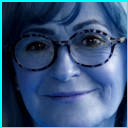

In [52]:
import numpy as np

data = test_recognized_faces['smiling-face'][7]
img = Image.fromarray(data)
print(type(img))
img.show()

In [45]:
train_dataframe = pd.DataFrame
train_dataframe.columns = [['photo', 'type']]

In [54]:
# print(train_dataframe)

<class 'pandas.core.frame.DataFrame'>


# **4.Model**

In [25]:
img_height = 64
img_width = 64
batch_size = 100

In [28]:
#train and validation split
train_dataset = tf.data.Dataset.from_tensor_slices((train_recognized_faces.values(), train_recognized_faces.keys()))

# val_ds = keras.utils.image_dataset_from_directory(
#     train_path,
#     validation_split = 0.3,
#     seed=0,
#     subset='validation',
#     image_size = (img_height, img_width),
#     batch_size = batch_size,
#     label_mode = 'categorical')

ValueError: ignored

In [ ]:
train_ds

NameError: ignored

In [ ]:
model = Sequential()
model.add(layers.Rescaling(1./255))

model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.RandomRotation(factor = (-1, 1), fill_mode='reflect', interpolation='bilinear',))

model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Rescaling(scale=2, offset=0.0))

model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))